In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

In [3]:
RUNDIR = "/lfs/1/keshav2/benchmarking/benchmark_output/runs/latest"

In [4]:
SCENARIOS = ["mmlu", "boolq"]

In [5]:
class Run:
    def __init__(self, key):
        scenario, args = key.split(":")
        args = args.split(",")
        self.scenario = scenario
        for arg in args:
            k, v = arg.split("=")
            setattr(self, k, v)
            
        self.runtimes = []
        self.idealized_runtimes = []
        self.exact_match = []
        with open(os.path.join(RUNDIR, key, "per_instance_metrics.json"), "r") as f:
            metrics = json.load(f)
            for instance in metrics:
                for metric in metrics[instance]:
                    if metric["name"]["name"] == "inference_runtime":
                        self.runtimes.append(float(metric["values"][0]))
                    elif metric["name"]["name"] == "inference_idealized_runtime":
                        if len(metric["values"]) > 0:
                            self.idealized_runtimes.append(float(metric["values"][0]))
                    elif metric["name"]["name"] == "exact_match":
                        self.exact_match.append(metric["values"][0])

In [6]:
runs = []
for run_key in os.listdir(RUNDIR):
    if any(run_key.startswith(scenario) for scenario in SCENARIOS):
        runs.append(Run(run_key))

In [7]:
runs_grouped_by_scenario = defaultdict(list)
for run in runs:
    if run.scenario == "mmlu":
        scenario = f"mmlu:subject={run.subject}"
    else:
        scenario = run.scenario
    runs_grouped_by_scenario[scenario].append(run)

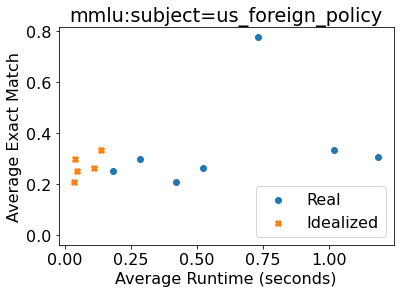

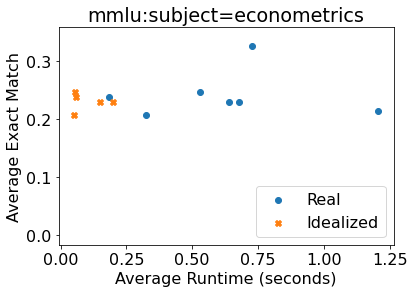

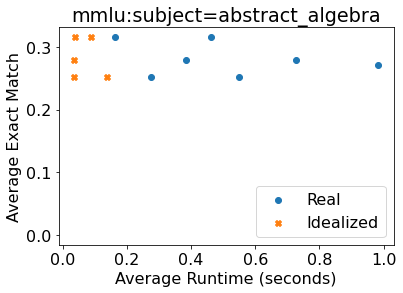

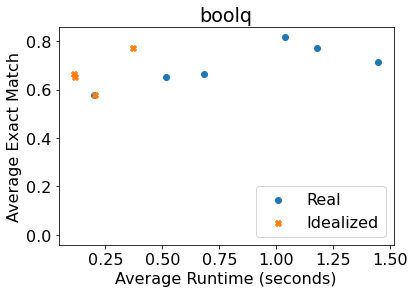

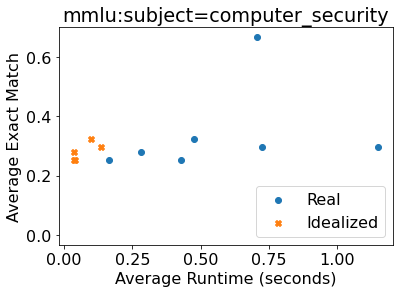

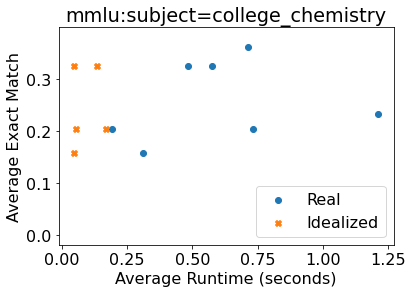

In [12]:
aggregated_data = []
for scenario in runs_grouped_by_scenario:
    per_scenario_runtimes = []
    per_scenario_idealized_runtimes = []
    per_scenario_exact_match = []
    for run in runs_grouped_by_scenario[scenario]:
        average_runtime = np.mean(run.runtimes)
        average_idealized_runtime = (
            np.mean(run.idealized_runtimes) if len(run.idealized_runtimes) > 0 else None
        )
        average_exact_match = (
            np.mean(run.exact_match) if len(run.exact_match) > 0 else None
        )
        aggregated_data.append(
            (
                scenario,
                run.model,
                average_runtime,
                average_idealized_runtime,
                average_exact_match,
            )
        )
        per_scenario_runtimes.append(average_runtime)
        per_scenario_idealized_runtimes.append(average_idealized_runtime)
        per_scenario_exact_match.append(average_exact_match)

    per_scenario_runtimes = np.array(per_scenario_runtimes)
    per_scenario_idealized_runtimes = np.array(per_scenario_idealized_runtimes)
    per_scenario_exact_match = np.array(per_scenario_exact_match)

    plt.figure()
    plt.scatter(
        per_scenario_runtimes[per_scenario_runtimes > 0],
        per_scenario_exact_match[per_scenario_runtimes > 0],
        marker="o",
        label="Real",
    )
    plt.scatter(
        per_scenario_idealized_runtimes[per_scenario_idealized_runtimes is not None],
        per_scenario_exact_match[per_scenario_idealized_runtimes is not None],
        marker="X",
        label="Idealized",
    )
    plt.legend(loc="lower right")
    plt.title(scenario)
    plt.xlabel("Average Runtime (seconds)")
    plt.ylabel("Average Exact Match")

In [9]:
df = pd.DataFrame(
    aggregated_data,
    columns=[
        "scenario",
        "model",
        "average_runtime",
        "average_idealized_runtime",
        "average_exact_match",
    ],
)
df.to_csv(
    "efficiency_vs_capability.csv",
    sep=",",
    index=False,
)